In [1]:
import nibabel as nib
from nilearn import plotting as nlp
import numpy as np

In [9]:
pathdata="/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess01/"
fmri_file="warped_F_sess01_res_ICA_filt_sm6.nii.gz"
fmri_file=pathdata+fmri_file
seed_file="/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/MIST_ROI_3mm.nii.gz"

In [3]:
seed_img = nib.load(seed_file)
seed_vol = seed_img.get_data()
len(np.unique(seed_vol))

211

In [4]:
fmri_img = nib.load(fmri_file)
fmri_vol = fmri_img.get_data()
print(fmri_vol.shape)

(61, 73, 61, 810)


In [5]:
TIME = fmri_vol.shape[-1]
fmri_vol_matrix = fmri_vol.reshape((np.prod(fmri_vol.shape[:-1]),TIME))
mean_vol = np.mean(fmri_vol_matrix, axis=1)
std_vol = np.std(fmri_vol_matrix, axis=1)

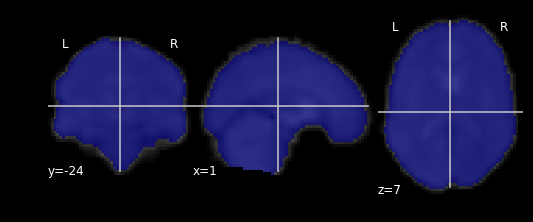

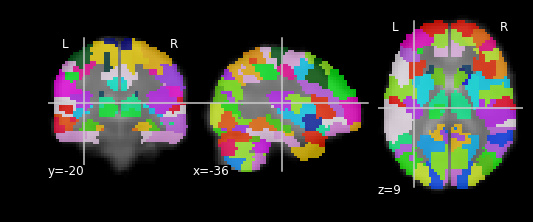

In [11]:
import matplotlib.pyplot as plt
% matplotlib inline

from nilearn import plotting
from nilearn.image import mean_img
from nilearn.input_data import NiftiMasker

masker_epi = NiftiMasker(mask_strategy='epi')
masker_epi.fit(fmri_file)

mean_fmri = mean_img(fmri_file)
plotting.plot_roi(masker_epi.mask_img_,mean_fmri)
plotting.plot_roi(seed_file,mean_fmri)

In [15]:
print(fmri_vol_matrix.shape)
print(mean_vol.shape)
mask_vol=masker_epi.mask_img_.get_data()

(271633, 810)
(271633,)


numpy.ndarray

In [17]:
from nilearn.masking import apply_mask
seed_roi = apply_mask(seed_img,masker_epi.mask_img_)
fmri_data = apply_mask(fmri_img,masker_epi.mask_img_)

print(seed_roi.shape)
print(fmri_data.shape)

(63636,)
(810, 63636)


In [36]:
from nilearn import datasets
powers = datasets.fetch_coords_power_2011()
dir(powers)
print(powers.keys())
#print(powers.rois)

coords = np.vstack((powers.rois['x'],powers.rois['y'],powers.rois['z'])).T
#print(coords)

from nilearn.input_data import NiftiSpheresMasker
roi_masker = NiftiSpheresMasker(seeds=coords, smoothing_fwhm=4, radius=5.,
    detrend=True, standardize=True, low_pass=0.1, high_pass=0.01, t_r=2.2)
roi_tc_data = roi_masker.fit_transform(fmri_file)
print(roi_tc_data.shape)

dict_keys(['rois', 'description'])
(810, 264)


In [37]:
from sklearn.covariance import GraphLassoCV
covariance_estimator = GraphLassoCV()
covariance_estimator.fit(roi_tc_data)
conn_matrix = covariance_estimator.covariance_
print(conn_matrix.shape)

/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/numpy/linalg/linalg.py:1741: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


(264, 264)


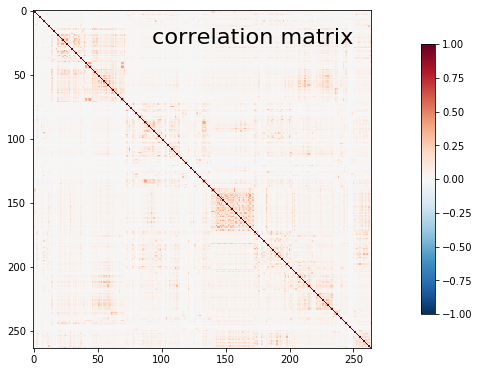

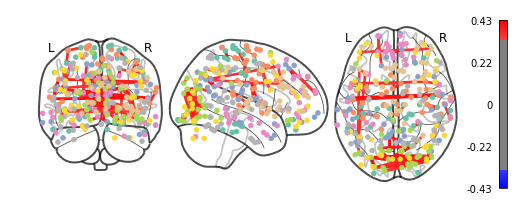

In [40]:
plotting.plot_matrix(conn_matrix,vmax=1.,vmin=-1.,colorbar=True,title='correlation matrix')
plotting.plot_connectome(conn_matrix,coords,edge_threshold='99.8%', node_size=20, colorbar=True)

/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/numpy/core/records.py:507: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.13 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/numpy/linalg/linalg.py:1741: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


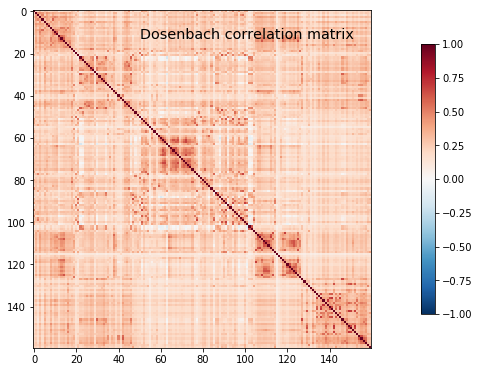

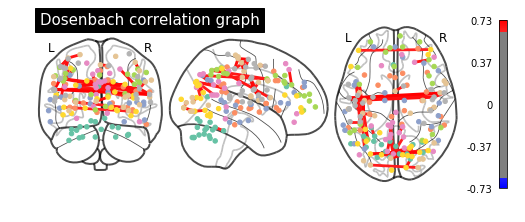

In [47]:
dosenbach = datasets.fetch_coords_dosenbach_2010()
coords = np.vstack(( dosenbach.rois['x'],dosenbach.rois['y'],dosenbach.rois['z'])).T

spheres_masker = NiftiSpheresMasker(seeds=coords, smoothing_fwhm=4, radius=4.5,
    detrend=True, standardize=True, low_pass=0.1, high_pass=0.01, t_r=2.5)

confounds_file=pathdata+"F_sess01_mc.1D"
timeseries = spheres_masker.fit_transform(fmri_file,confounds=confounds_file)

covariance_estimator = GraphLassoCV()
covariance_estimator.fit(timeseries)
matrix = covariance_estimator.covariance_

plotting.plot_matrix(matrix, vmin=-1., vmax=1., colorbar=True,
                     title='Dosenbach correlation matrix')

plotting.plot_connectome(matrix, coords, title='Dosenbach correlation graph',
                         edge_threshold="99.7%", node_size=20, colorbar=True)

[b'cerebellum' b'cingulo-opercular' b'default' b'fronto-parietal'
 b'occipital' b'sensorimotor']
(810, 6)


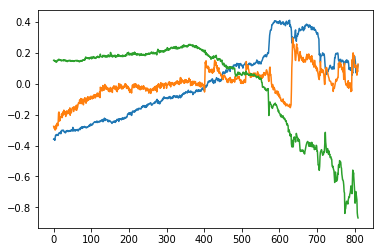

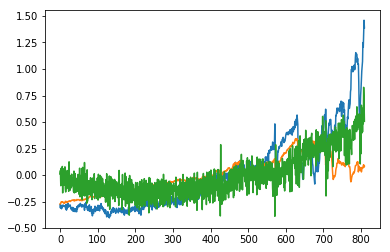

In [54]:
print(np.unique(dosenbach.networks))
head_motion = np.loadtxt(confounds_file)
print(head_motion.shape)

plt.figure()
plt.plot(head_motion[:,:3])
plt.figure()
plt.plot(head_motion[:,3:])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82]


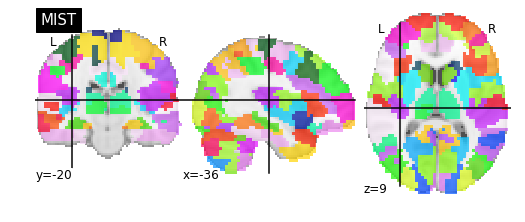

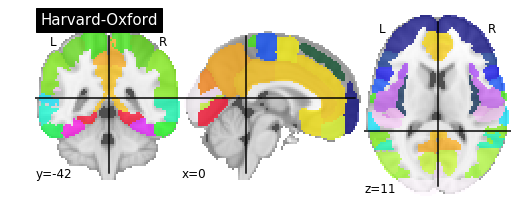

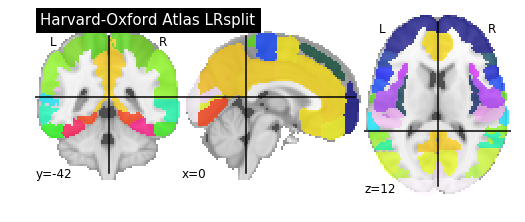

In [79]:
seed_file="/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/MIST_ROI_3mm.nii.gz"
plotting.plot_roi(seed_file,title='MIST')

harvard_atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
harvard_atlas_file = harvard_atlas.maps
harvard_atlas_label = harvard_atlas.labels
#print((harvard_atlas_label))
plotting.plot_roi(harvard_atlas_file,title='Harvard-Oxford')

from nilearn.regions import connected_label_regions
harvard_atlas_LRsp = connected_label_regions(harvard_atlas_file)
plotting.plot_roi(harvard_atlas_LRsp,title='Harvard-Oxford Atlas LRsplit')
print(np.unique(harvard_atlas_LRsp.get_data()))

In [91]:
def extract_tc_atlas(fmri_file,seed_file,head_motion=False,TR=2.5,connectivity_type=1):
    from nilearn.input_data import NiftiLabelsMasker
    atlas_masker = NiftiLabelsMasker(labels_img=seed_file,
                                     detrend=True, standardize=True, low_pass=0.1, high_pass=0.01, t_r=TR)
    try:
        atlas_tc_data = atlas_masker.fit_transform(fmri_file,confounds=head_motion)
    except:
        atlas_tc_data = atlas_masker.fit_transform(fmri_file)
    print(atlas_tc_data.shape)
    
    from nilearn.connectome import ConnectivityMeasure
    conn_type={1:"correlation", 
               2:"partial correlation", 
               3:"tangent", 
               4:"covariance", 
               5:"precision"}
    
    print("calculate conn %s between pairs of parcels" % conn_type[connectivity_type])
    conn_measure = ConnectivityMeasure(kind=conn_type[connectivity_type])
    conn_matrix = conn_measure.fit_transform([atlas_tc_data])[0]
    #conn_matrix = conn_measure.fit([atlas_tc_data])
    np.fill_diagonal(conn_matrix,0)
    
    import matplotlib.pyplot as plt
    from nilearn import plotting
    plt.figure()
    plotting.plot_matrix(conn_matrix, vmin=-1., vmax=1., colorbar=True,
                     title=conn_type[connectivity_type])

#extract_tc_atlas(fmri_file,seed_file,confounds_file,2.2)

(810, 210)
calculate conn correlation between pairs of parcels
(810, 210)
calculate conn correlation between pairs of parcels
(810, 48)
calculate conn correlation between pairs of parcels
(810, 82)
calculate conn correlation between pairs of parcels


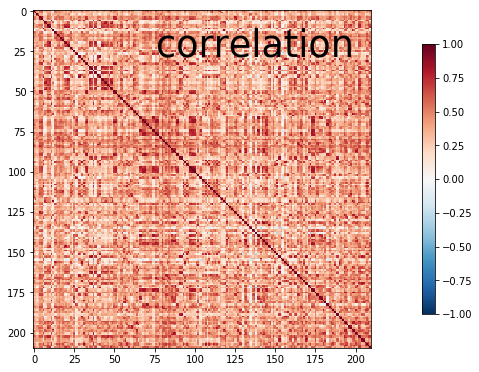

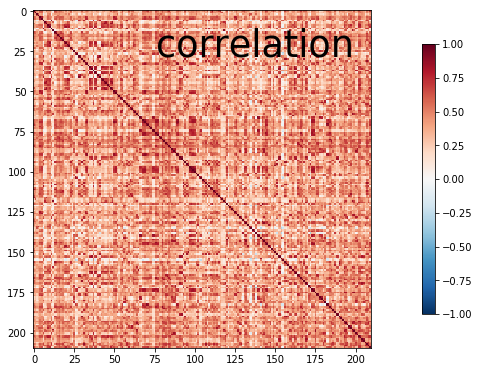

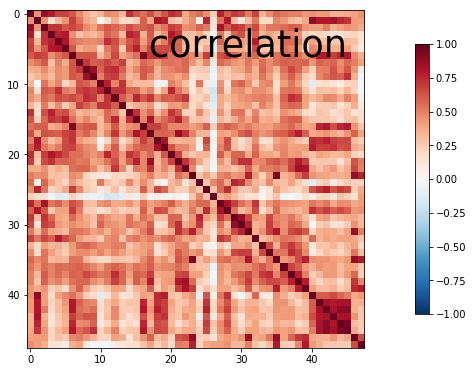

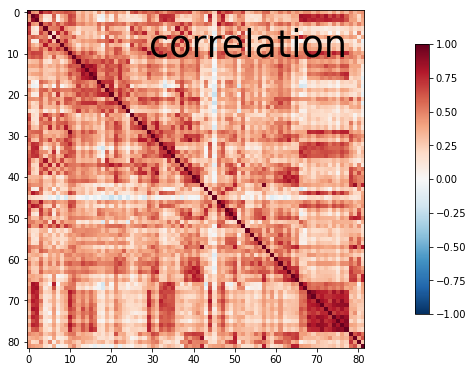

In [85]:
extract_tc_atlas(fmri_file,seed_file,confounds_file,TR=2.2,connectivity_type=1)
extract_tc_atlas(fmri_file,seed_file,TR=2.2,connectivity_type=1)
extract_tc_atlas(fmri_file,harvard_atlas_file,confounds_file,TR=2.2)
extract_tc_atlas(fmri_file,harvard_atlas_LRsp,confounds_file,TR=2.2)


/home/yzhang/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii [b'L Aud', b'R Aud', b'Striate', b'L DMN', b'Med DMN', b'Front DMN', b'R DMN', b'Occ post', b'Motor', b'R DLPFC', b'R Front pol', b'R Par', b'R Post Temp', b'Basal', b'L Par', b'L DLPFC', b'L Front pol', b'L IPS', b'R IPS', b'L LOC', b'Vis', b'R LOC', b'D ACC', b'V ACC', b'R A Ins', b'L STS', b'R STS', b'L TPJ', b'Broca', b'Sup Front S', b'R TPJ', b'R Pars Op', b'Cereb', b'Dors PCC', b'L Ins', b'Cing', b'R Ins', b'L Ant IPS', b'R Ant IPS']


/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/matplotlib/contour.py:1180: UserWarning:

No contour levels were found within the data range.



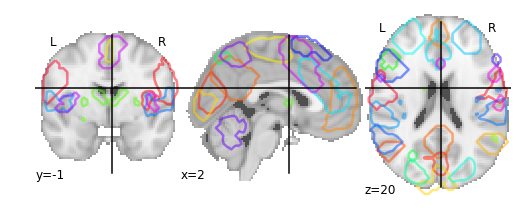

In [88]:
msdl_atlas = datasets.fetch_atlas_msdl()
msdl_atlas_file = msdl_atlas.maps
msdl_atlas_label = msdl_atlas.labels
print(msdl_atlas_file,msdl_atlas_label)

plotting.plot_prob_atlas(msdl_atlas_file)

39
(810, 39)


/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/numpy/linalg/linalg.py:1741: RuntimeWarning:

invalid value encountered in slogdet

/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/covariance/graph_lasso_.py:252: ConvergenceWarning:

graph_lasso: did not converge after 100 iteration: dual gap: -6.075e-04



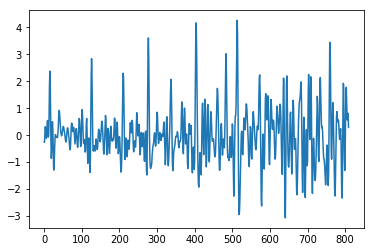

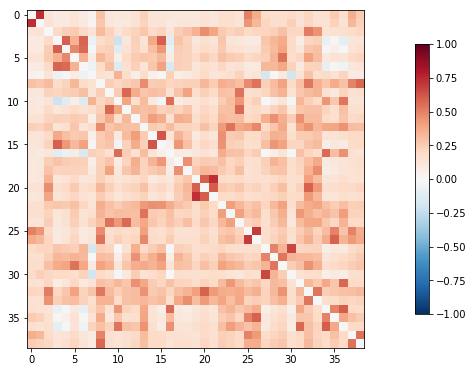

In [106]:
print(len(msdl_atlas_label))

from nilearn.input_data import NiftiMapsMasker
msdl_maps = NiftiMapsMasker(maps_img=msdl_atlas_file,standardize=True)
msdl_roi_tc = msdl_maps.fit_transform(fmri_file,confounds=confounds_file)
print(msdl_roi_tc.shape)

#plotting.plot_matrix(msdl_roi_tc)
plt.plot(msdl_roi_tc[:,1])

covariance_estimator = GraphLassoCV()
covariance_estimator.fit(msdl_roi_tc)
conn_matrix = covariance_estimator.covariance_
np.fill_diagonal(conn_matrix,0)
plotting.plot_matrix(conn_matrix,vmin=-1., vmax=1., colorbar=True)

(39, 39)


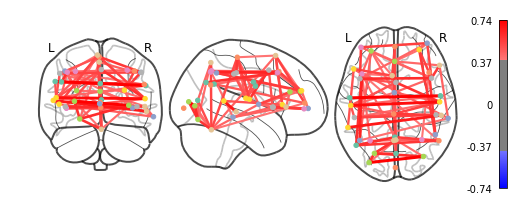

In [107]:
#dir(msdl_atlas)
print(conn_matrix.shape)
coords = msdl_atlas.region_coords
plotting.plot_connectome(conn_matrix,coords,edge_threshold="90%",node_size=20, colorbar=True)

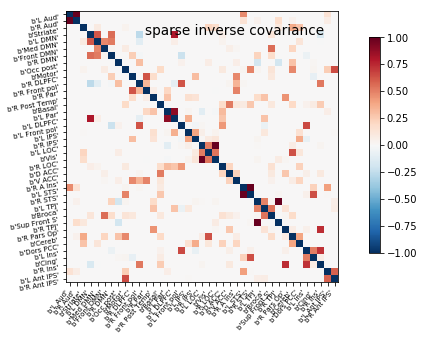

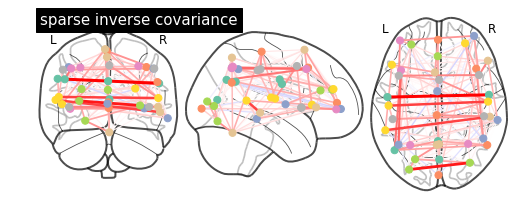

In [108]:
plotting.plot_matrix(-covariance_estimator.precision_,labels=msdl_atlas_label,vmax=1.,vmin=-1.,title='sparse inverse covariance')

coords=msdl_atlas.region_coords
plotting.plot_connectome(-covariance_estimator.precision_,coords,title='sparse inverse covariance')

In [100]:
print(np.unique(msdl_atlas.networks))
print(msdl_atlas.region_coords)

[b'Ant IPS' b'Aud' b'Basal' b'Cereb' b'Cing-Ins' b'D Att' b'DMN'
 b'Dors PCC' b'L V Att' b'Language' b'Motor' b'Occ post' b'R V Att'
 b'Salience' b'Striate' b'Temporal' b'Vis Sec']
[(-53.28, -8.88, 32.36), (53.47, -6.49, 27.52), (1.18, -74.54, 10.79), (-45.8, -64.78, 31.84), (-0.2, -55.21, 29.87), (-0.15, 51.42, 7.58), (51.66, -59.34, 28.88), (0.41, -91.05, 1.58), (-1.48, -27.93, 61.5), (40.1, 20.96, 44.72), (37.83, 55.49, 1.22), (47.53, -52.42, 43.06), (62.53, -32.99, -9.14), (-0.91, -2.75, 6.15), (-41.66, -59.04, 44.61), (-39.04, 19.28, 43.27), (-40.08, 50.65, 0.81), (-29.39, -59.43, 44.2), (31.6, -58.09, 45.69), (-30.54, -85.14, 9.1), (-24.29, -74.28, -11.74), (33.4, -77.96, 4.31), (-28.17, 46.32, 21.56), (-0.45, 34.06, 20.73), (28.38, 47.72, 22.13), (-52.12, -17.92, 13.28), (52.61, -13.65, 12.11), (-55.52, -43.77, 10.08), (-48.66, 25.11, 5.7), (-3.39, 17.19, 63.52), (54.42, -29.5, -2.72), (52.38, 29.39, 2.93), (1.05, -58.49, -23.91), (-1.44, -59.12, 55.25), (-41.33, 13.63, 2.7), (1

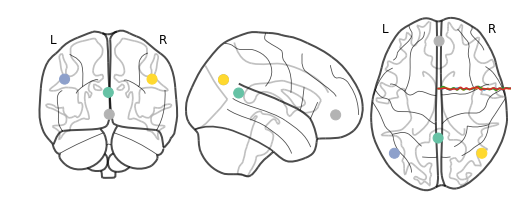

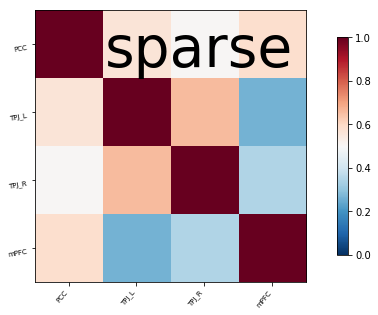

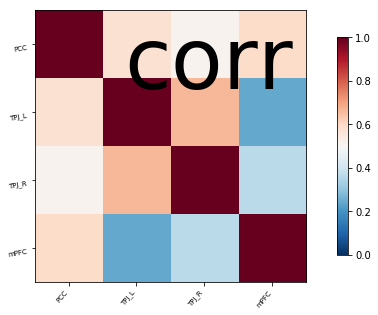

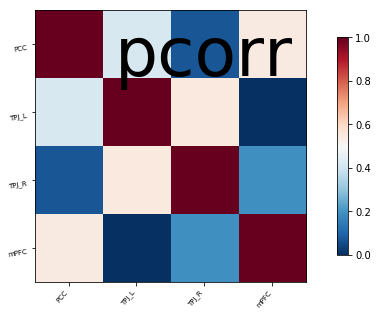

In [130]:
###DMN
dmn_coords = [(0, -52, 18), (-46, -68, 32), (46, -68, 32), (1, 50, -5)]
dmn_labels = ['PCC',
              'TPJ_L',
              'TPJ_R',
              'mPFC']

from nilearn.input_data import NiftiSpheresMasker
roi_sphere = NiftiSpheresMasker(seeds=dmn_coords, smoothing_fwhm=4, radius=6,
                                detrend=True, standardize=True, low_pass=0.1, high_pass=0.01, t_r=2.2)

plotting.plot_connectome(np.eye(len(dmn_coords)),dmn_coords,node_size=100)

dmn_roi_tc = roi_sphere.fit_transform(fmri_file,confounds=confounds_file)
for tc,label in zip(dmn_roi_tc.T,dmn_labels):
    #plt.figure()
    plt.plot(tc,label=label)

from sklearn.covariance import GraphLassoCV
covariance_estimator = GraphLassoCV()
covariance_estimator.fit(dmn_roi_tc)
conn_matrix = covariance_estimator.covariance_
plotting.plot_matrix(conn_matrix,labels=dmn_labels,vmax=1.,vmin=0.,title='sparse')

from nilearn.connectome import ConnectivityMeasure
corr_coef = ConnectivityMeasure(kind='correlation')
corr_matrix = corr_coef.fit_transform([dmn_roi_tc])[0]
plotting.plot_matrix(corr_matrix,labels=dmn_labels,vmax=1.,vmin=0.,title='corr')


pcorr_coef=ConnectivityMeasure(kind='partial correlation')
pcorr_matrix = pcorr_coef.fit_transform([dmn_roi_tc])[0]
plotting.plot_matrix(pcorr_matrix,labels=dmn_labels,vmax=1.,vmin=0.,title='pcorr')


In [125]:
print(dmn_coords)
print(len(dmn_coords))
print(conn_matrix)
print(corr_matrix)
print(pcorr_matrix)

[(0, -52, 18), (-46, -68, 32), (46, -68, 32), (1, 50, -5)]
4
[[ 1.          0.56470895  0.50463558  0.5826737 ]
 [ 0.56470895  1.          0.65637248  0.26374431]
 [ 0.50463558  0.65637248  1.          0.35145896]
 [ 0.5826737   0.26374431  0.35145896  1.        ]]
[[ 1.          0.57567995  0.51627125  0.5934418 ]
 [ 0.57567995  1.          0.66633202  0.24369602]
 [ 0.51627125  0.66633202  1.          0.36475816]
 [ 0.5934418   0.24369602  0.36475816  1.        ]]
[[ 1.          0.42064043  0.07323671  0.54482805]
 [ 0.42064043  1.          0.54776105 -0.22846887]
 [ 0.07323671  0.54776105  1.          0.19413045]
 [ 0.54482805 -0.22846887  0.19413045  1.        ]]


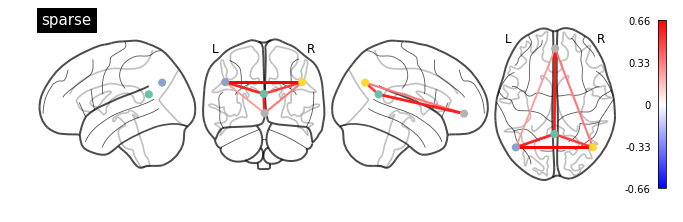

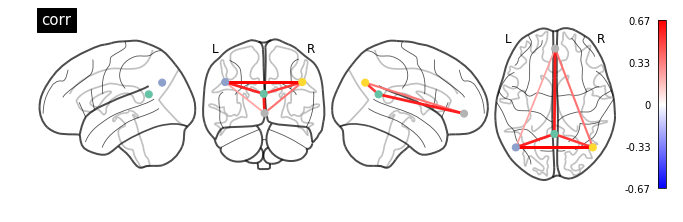

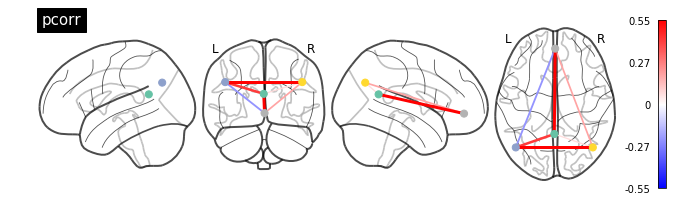

In [132]:
plotting.plot_connectome(conn_matrix,dmn_coords,display_mode='lyrz',title='sparse',colorbar=True)

plotting.plot_connectome(corr_matrix,dmn_coords,display_mode='lyrz',title='corr',colorbar=True)

plotting.plot_connectome(pcorr_matrix,dmn_coords,display_mode='lyrz',title='pcorr',colorbar=True)

In [133]:
# Generate synthetic data
from nilearn._utils.testing import generate_group_sparse_gaussian_graphs

n_subjects = 20  # number of subjects
n_displayed = 3  # number of subjects displayed
subjects, precisions, topology = generate_group_sparse_gaussian_graphs(
    n_subjects=n_subjects, n_features=10, min_n_samples=30, max_n_samples=50,
    density=0.1)

In [141]:
print(subjects[0].shape)
print(precisions)

(32, 10)
[array([[ 1.        ,  0.7803615 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.7803615 ,  1.60896407,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.71473543,  0.        ,  0.        ,  0.45673706],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.13900029,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.41581145],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.71473543,  0.        ,  0.        ,
         0.        ,  1.51084673,  

In [147]:
dosenbach = datasets.fetch_coords_dosenbach_2010()
print(dosenbach.rois.shape )

power = datasets.fetch_coords_power_2011()
print(power.rois.shape)

(160,)
(264,)


/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/numpy/core/records.py:507: FutureWarning:

Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.13 because this will return a view instead of a copy -- see release notes for details.



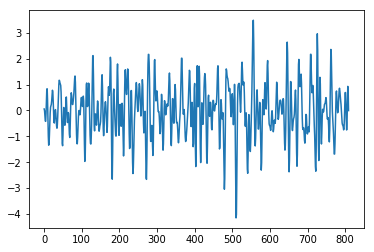

In [162]:
from nilearn.input_data import NiftiSpheresMasker, NiftiMasker
pcc_coords = [(0, -52, 18)]
pcc_masker = NiftiSpheresMasker(pcc_coords,radius=8,low_pass=0.1,high_pass=0.01,t_r=2.2,
                                smoothing_fwhm=6,detrend=True,standardize=True)
pcc_tc = pcc_masker.fit_transform(fmri_file,confounds=confounds_file)
plt.plot(pcc_tc)

brain_voxel_masker = NiftiMasker(masker_epi.mask_img_,smoothing_fwhm=6,low_pass=0.1,high_pass=0.01,t_r=2.2,
                                detrend=True,standardize=True)
brain_voxel_tc = brain_voxel_masker.fit_transform(fmri_file,confounds=confounds_file)


(810, 1) (810, 63636)
1.0
0.994621170259 -0.428497297229
2.9578692957 -0.458054558576
(61, 73, 61, 1)


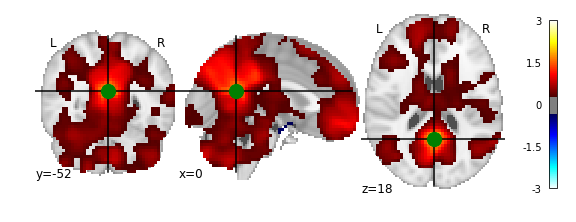

In [163]:
print(pcc_tc.shape,brain_voxel_tc.shape)
print(np.linalg.norm(pcc_tc)/np.sqrt(len(pcc_tc)))

brain_conn = np.dot(pcc_tc.T,brain_voxel_tc)/len(pcc_tc)
print(brain_conn.max(),brain_conn.min())

brain_conn_zscore = np.arctanh(brain_conn)
print(brain_conn_zscore.max(),brain_conn_zscore.min())

zmaps_brain_conn = brain_voxel_masker.inverse_transform(brain_conn_zscore)
print(zmaps_brain_conn.shape)

fig1=plotting.plot_stat_map(zmaps_brain_conn,threshold=.3,cut_coords=pcc_coords[0])
fig1.add_markers(marker_coords=pcc_coords,marker_color='g',marker_size=200)

In [199]:
###multiple subjects
from pathlib import Path
pathroot=Path('/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/')
subject = 'sub01'
modality = 'rest'

pathdata = pathroot/subject/modality
print(pathdata)

pathdata.exists()
pathdata.is_dir()

import glob
fmri_files = [];
confound_files = [];
#for file,confound in zip(pathdata.glob('sess*/warped_F_sess*_res_ICA_filt_sm6.nii.gz'),pathdata.glob('sess*/*.1D')):
#    fmri_files.append(file)
#    confound_files.append(confound)
for file in sorted(pathdata.glob('sess*/warped_F_sess*_res_ICA_filt_sm6.nii.gz')):
    fmri_files.append(str(file))

for confound in sorted(pathdata.glob('sess*/*.1D')):
    confound_files.append(str(confound))
    
print(fmri_files)
print(confound_files)

/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest
['/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess01/warped_F_sess01_res_ICA_filt_sm6.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess02/warped_F_sess02_res_ICA_filt_sm6.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess03/warped_F_sess03_res_ICA_filt_sm6.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess04/warped_F_sess04_res_ICA_filt_sm6.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess05/warped_F_sess05_res_ICA_filt_sm6.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess06/warped_F_sess06_res_ICA_filt_sm6.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess07/warped_F_sess07_res_ICA_filt_sm6.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess08/warped_F_sess08_res_

In [181]:
for file in sorted(pathdata.glob('sess*/*.1D')):
    print(file)

/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess01/F_sess01_mc.1D
/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess02/F_sess02_mc.1D
/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess03/F_sess03_mc.1D
/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess04/F_sess04_mc.1D
/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess05/F_sess05_mc.1D
/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess06/F_sess06_mc.1D
/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess07/F_sess07_mc.1D
/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess08/F_sess08_mc.1D
/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess09/F_sess09_mc.1D
/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess10/F_sess10_mc.1D


/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/MIST_ROI_3mm.nii.gz


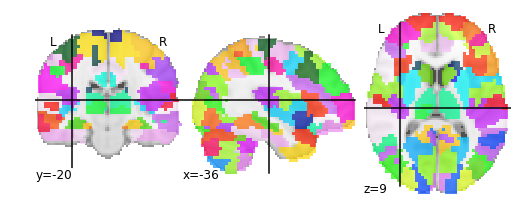

In [214]:
##group atlas for all subjects/sessions
mist_atlas_file = "/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/MIST_ROI_3mm.nii.gz"
print(mist_atlas_file)
plotting.plot_roi(mist_atlas_file)
TR = 2.2



from nilearn.image import mean_img, high_variance_confounds
from nilearn.input_data import NiftiMasker
from nilearn.input_data import NiftiLabelsMasker

subjects_tc_matrix = [];
for fmri_file,confound_file in zip(fmri_files,confound_files):
    #fmri_file = fmri_files[0]
    #confound_file = confound_files[0]
    brain_masker = NiftiMasker(mask_strategy='epi')
    brain_masker.fit_transform(fmri_file)
    mean_fmri = mean_img(fmri_file)
    ##adjust group atlas to individual brain mask
    mist_atlas = NiftiLabelsMasker(labels_img=mist_atlas_file,mask_img=brain_masker.mask_img_,
                                  detrend=True, standardize=True, low_pass=0.1, high_pass=0.01, t_r=TR)
    #plotting.plot_roi(mist_atlas.mask_img_,mean_fmri)
    highvar_confound = high_variance_confounds(fmri_file)
    mist_roi_tc = mist_atlas.fit_transform(fmri_file,confounds=[highvar_confound,confound_file])
    subjects_tc_matrix.append(mist_roi_tc)

(810, 5)


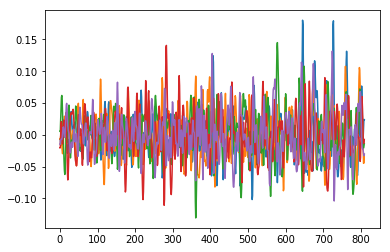

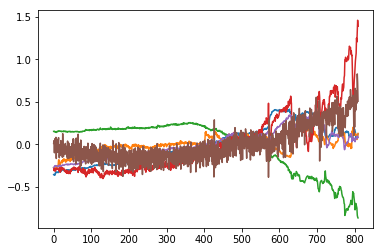

In [211]:

from nilearn.image import mean_img, high_variance_confounds
highvar_confound = high_variance_confounds(fmri_file)
print(highvar_confound.shape)
plt.plot(highvar_confound)
plt.figure()
head_motion = np.loadtxt(confound_file)
plt.plot(head_motion)

In [ ]:
print(mist_roi_tc.shape)
print(len(subjects_tc_matrix),subjects_tc_matrix[0].shape)

from nilearn.connectome import GroupSparseCovarianceCV
gsv = GroupSparseCovarianceCV()
gsv.fit(subjects_tc_matrix)
plotting.plot_matrix(gsv.covariance_,cmap=plotting.cm.bwr,vmin=-1, vmax=1)

from sklearn.covariance import GraphLassoCV
gl = GraphLassoCV()
gl.fit(np.concatenate(subjects_tc_matrix))
plotting.plot_matrix(gl.covariance_,cmap=plotting.cm.bwr,vmin=-1, vmax=1)


(810, 210)
(810, 210)


/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/nilearn/connectome/group_sparse_cov.py:446: UserWarning:

Maximum number of iterations reached without getting to the requested tolerance level.

